<a href="https://colab.research.google.com/github/benagabi/classification-of-earning-using-lumn-algorithm/blob/main/Classification_of_earnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!mkdir data
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O ./data/adult.csv
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O ./data/adult_test.csv

In [4]:
!pip install lumin
!git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from collections import OrderedDict, defaultdict

In [2]:
from pathlib import Path

PATH = Path('data/')

In [3]:
df = pd.read_csv(PATH/'adult.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
print(len(df))

32561


In [5]:
df_test = pd.read_csv(PATH/'adult_test.csv', header=None, skiprows=[0])
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.


In [6]:
df_test.shape

(16281, 15)

In [7]:
df.columns = [ "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation",
              "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Target"]
df_test.columns = df.columns
df.head(1)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [8]:
df.Target.unique()

array([' <=50K', ' >50K'], dtype=object)

In [9]:
df['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})
df_test['Target'] = df.Target.map({' <=50K': 0, ' >50K': 1})

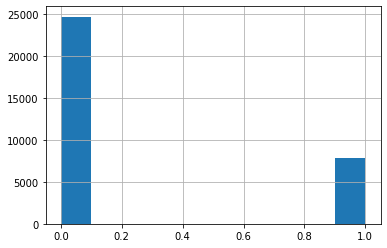

In [10]:
df.Target.hist()

In [12]:
from sklearn.model_selection import train_test_split

_, val_ids = train_test_split(df.index, stratify=df.Target, test_size=0.2, random_state=0)

In [13]:
df['val'] = 0
df.loc[val_ids, 'val'] = 1

In [11]:
#Feature Processing
cat_feats = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']
cont_feats = ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
train_feats = cont_feats+cat_feats

In [14]:
#Categorical Encoding
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    print(feat, set(df[feat]) == set(df_test[feat]))

WorkClass True
Education True
MaritalStatus True
Occupation True
Relationship True
Race True
Gender True
NativeCountry False


In [15]:
print('Missing from test:',  [f for f in set(df.NativeCountry) if f not in set(df_test.NativeCountry)])
print('Missing from train:', [f for f in set(df_test.NativeCountry) if f not in set(df.NativeCountry)])

Missing from test: [' Holand-Netherlands']
Missing from train: []


In [16]:
#Integer mapping
cat_maps = defaultdict(dict)
for feat in ['WorkClass', 'Education', 'MaritalStatus', 'Occupation',
             'Relationship', 'Race', 'Gender', 'NativeCountry']:
    for i, val in enumerate(set(df[feat])):
        cat_maps[feat][val] = i
        df.loc[df[feat] == val, feat] = i
        df_test.loc[df_test[feat] == val, feat] = i

In [17]:
df.head(2)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Target,val
0,39,4,77516,12,13,0,0,3,3,0,2174,0,40,33,0,0
1,50,2,83311,12,13,5,13,0,3,0,0,0,13,33,0,0


In [18]:
#Continuous preprocessing
from lumin.data_processing.pre_proc import fit_input_pipe

input_pipe = fit_input_pipe(df[df.val == 0], cont_feats=cont_feats, savename=PATH/'input_pipe', norm_in=True)

In [19]:
df[cont_feats] = input_pipe.transform(df[cont_feats].values.astype('float32'))
df_test[cont_feats] = input_pipe.transform(df_test[cont_feats].values.astype('float32'))

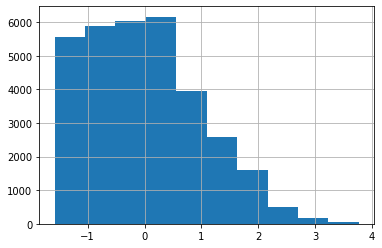

In [20]:
df.Age.hist()

In [21]:
#Data weighting
df['weight'] = 1
df.loc[(df.val==0)&(df.Target==0), 'weight'] = 1/len(df[(df.val==0)&(df.Target==0)])
df.loc[(df.val==0)&(df.Target==1), 'weight'] = 1/len(df[(df.val==0)&(df.Target==1)])
print(df.loc[(df.val==0)&(df.Target==0), 'weight'].sum(), df.loc[(df.val==0)&(df.Target==1), 'weight'].sum())

1.0 0.9999999999999997


In [22]:
#Saving to foldfile
from lumin.data_processing.file_proc import df2foldfile

df2foldfile(df=df[df.val==0], n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            wgt_feat='weight', savename=PATH/'train', targ_type='int')

Saving fold 0 with 2605 events
Saving fold 1 with 2605 events
Saving fold 2 with 2605 events
Saving fold 3 with 2605 events
Saving fold 4 with 2605 events
Saving fold 5 with 2605 events
Saving fold 6 with 2605 events
Saving fold 7 with 2605 events
Saving fold 8 with 2604 events
Saving fold 9 with 2604 events


In [23]:
df2foldfile(df=df[df.val==1], n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            savename=PATH/'val', targ_type='int')

Saving fold 0 with 652 events
Saving fold 1 with 652 events
Saving fold 2 with 652 events
Saving fold 3 with 651 events
Saving fold 4 with 651 events
Saving fold 5 with 651 events
Saving fold 6 with 651 events
Saving fold 7 with 651 events
Saving fold 8 with 651 events
Saving fold 9 with 651 events


In [24]:
df2foldfile(df=df_test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats='Target',
            savename=PATH/'test', targ_type='int')

Saving fold 0 with 1629 events
Saving fold 1 with 1628 events
Saving fold 2 with 1628 events
Saving fold 3 with 1628 events
Saving fold 4 with 1628 events
Saving fold 5 with 1628 events
Saving fold 6 with 1628 events
Saving fold 7 with 1628 events
Saving fold 8 with 1628 events
Saving fold 9 with 1628 events


In [25]:
from lumin.nn.data.fold_yielder import FoldYielder

train_fy = FoldYielder(PATH/'train.hdf5')
train_fy

FoldYielder with 10 folds, containing ['inputs', 'targets', 'weights']

In [26]:
#Model Training
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder

bs = 64
objective = 'classification'
model_args = {'body':{'act':'relu', 'width':100, 'depth':2, 'do':0.20}}
opt_args = {'opt':'adam', 'eps':1e-08, 'weight_decay':1e-7}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
6 Continuous: ['Age', 'fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
                   
8  Categorical: ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Gender', 'NativeCountry']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(9, 5)
      (1): Embedding(16, 8)
      (2): Embedding(7, 4)
      (3): Embedding(15, 8)
      (4): Embedding(6, 3)
      (5): Embedding(5, 3)
      (6): Embedding(2, 1)
      (7): Embedding(42, 21)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=59, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)


In [27]:
from lumin.nn.callbacks.opt_callbacks import LRFinder

model = Model(model_builder)
lrf = LRFinder(lr_bounds=[1e-5,1e-1])
_ = model.fit(n_epochs=1,  # Train for one epoch
              fy=train_fy,  # Pass our training data
              bs=bs,  # Set batch size
              cbs=lrf)  # Pass the LR-finder as a callback

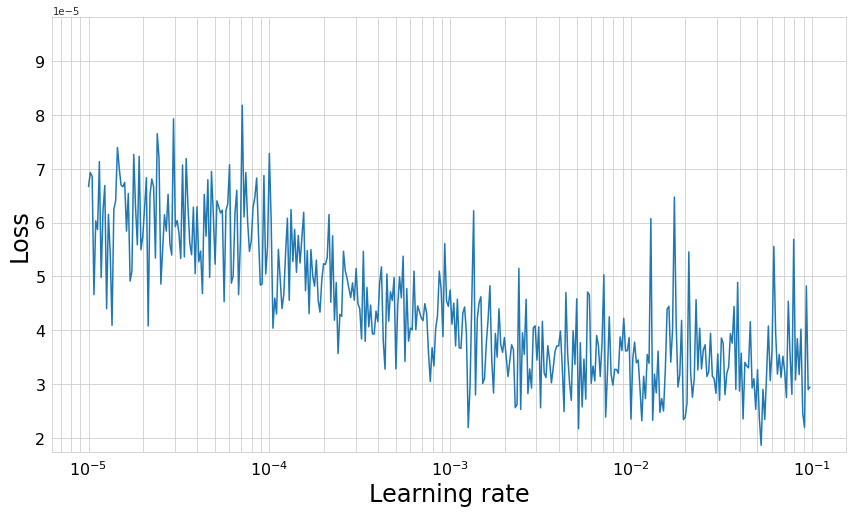

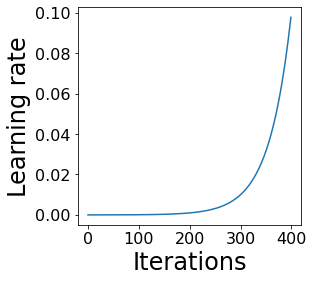

(None, None)

In [28]:
lrf.plot(), lrf.plot_lr()

LR finder took 17.298s 


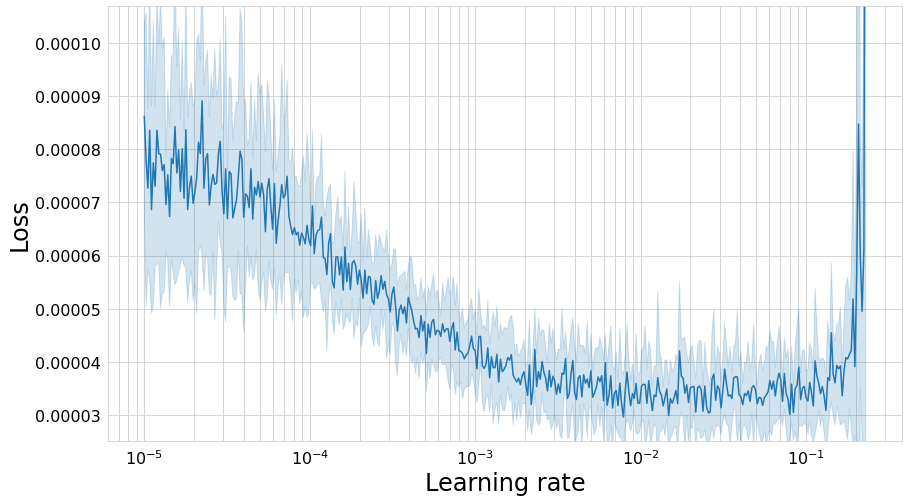

In [29]:
from lumin.optimisation.hyper_param import lr_find

lr_finder = lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [30]:
model_builder.set_lr(1e-3)

In [31]:
import matplotlib.pyplot as plt
from lumin.nn.callbacks.monitors import SaveBest, EarlyStopping, MetricLogger

model = Model(model_builder)
save_best = SaveBest()  # Save a copy of the model whenever the loss improves
logger = MetricLogger(show_plots=False)  # Track training and validation losses and print losses
early_stop = EarlyStopping(patience=1)  # End training early if loss doesn't improve after 5 epochs
_ = model.fit(n_epochs=30,  # Train for 30 epoch
              fy=train_fy,  # Pass our training data
              bs=bs,  # Set batch size
              cbs=[logger, save_best, early_stop],  # Pass the callbacks
              val_idx=0  # Use fold zero of train_fy as validation data and train on folds 1-9
             )

Epoch 1: Training = 3.50E-05 Validation = 3.04E-05
Epoch 2: Training = 3.07E-05 Validation = 3.00E-05
Epoch 3: Training = 2.97E-05 Validation = 2.91E-05
Epoch 4: Training = 2.91E-05 Validation = 2.89E-05
Epoch 5: Training = 2.90E-05 Validation = 2.87E-05
Epoch 6: Training = 2.88E-05 Validation = 2.87E-05
Epoch 7: Training = 2.85E-05 Validation = 2.84E-05
Epoch 8: Training = 2.87E-05 Validation = 2.85E-05
Early stopping
Loading best model with metric value 2.845E-05


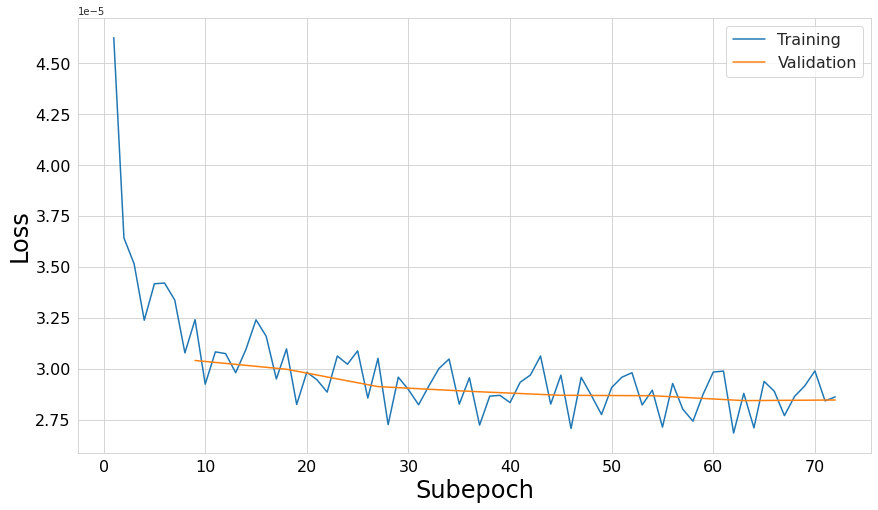

In [32]:
from lumin.plotting.training import plot_train_history

history = logger.get_loss_history()
plot_train_history(history)

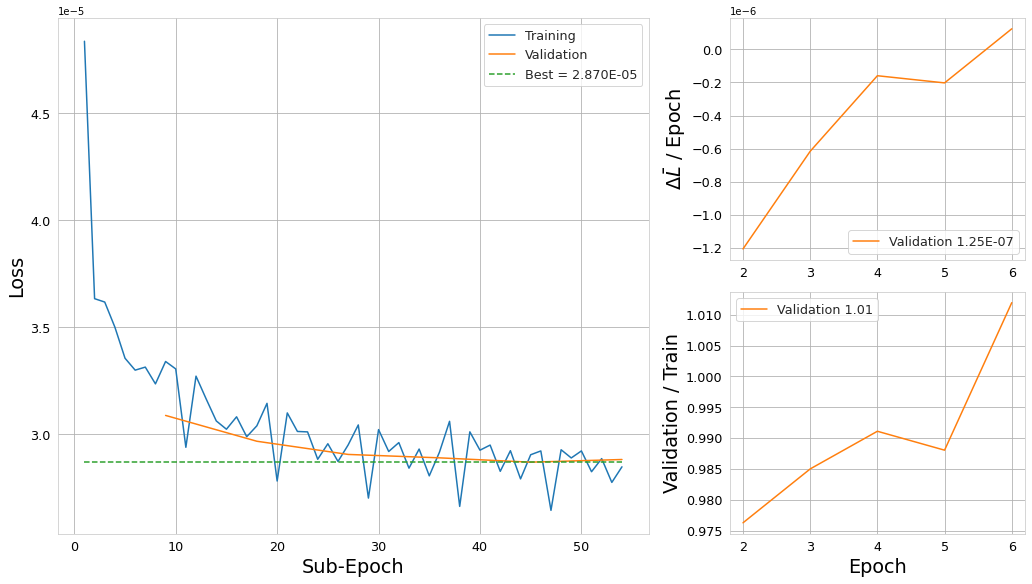

Early stopping
Loading best model with metric value 2.870E-05


<Figure size 1024x576 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
from lumin.nn.callbacks.monitors import SaveBest, EarlyStopping, MetricLogger

model = Model(model_builder)
cbs = [
    MetricLogger(show_plots=True, extra_detail=True),  # Track training and validation losses and show a live plot
    SaveBest(),  # Save a copy of the model whenever the loss improves
    EarlyStopping(patience=1)  # End training early if loss doesn't improve after 5 epochs
]
_ = model.fit(n_epochs=30,  # Train for 30 epoch
              fy=train_fy,  # Pass our training data
              bs=bs,  # Set batch size
              cbs=cbs,  # Pass the callbacks
              val_idx=0  # Use fold zero of train_fy as validation data and train on folds 1-9
             )
plt.clf()  # prevent the plot from showing twice

In [34]:
from lumin.nn.metrics.class_eval import BinaryAccuracy, RocAucScore

metric_partials = [RocAucScore, BinaryAccuracy]

Training model 1 / 1, Val ID = 0


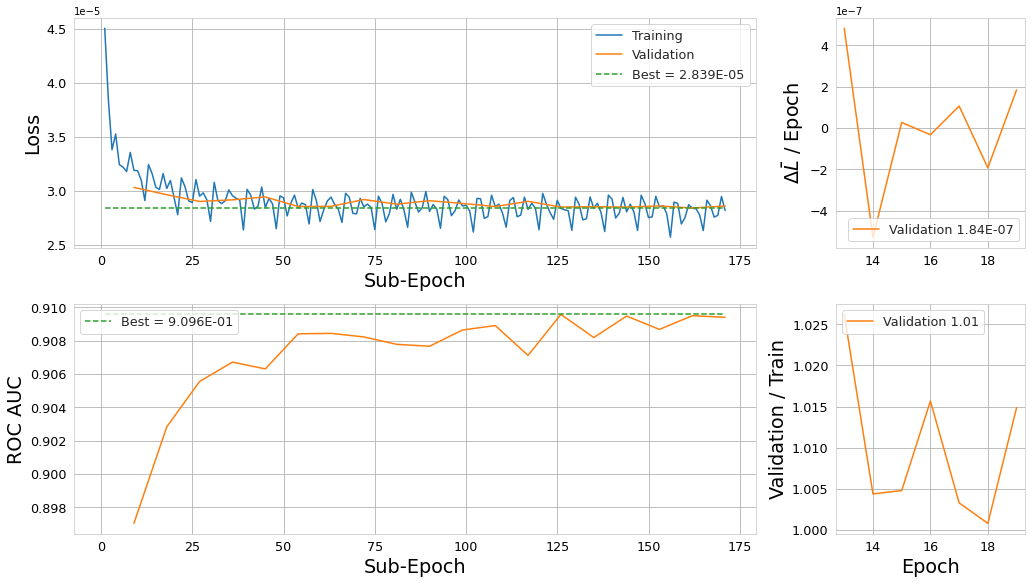

Early stopping
Loading best model with metric value -9.096E-01
Model took 74.826s

Scores are: {'loss': 2.8480570108513348e-05, 'ROC AUC': 0.9095825405454381, 'Acc': 0.823145201270627}

______________________________________
Training finished
Cross-validation took 74.962s 


<Figure size 1024x576 with 0 Axes>

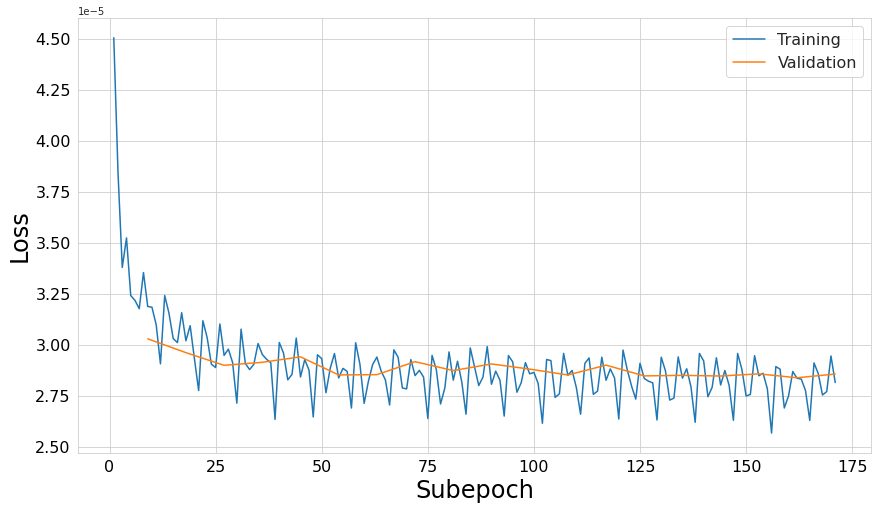

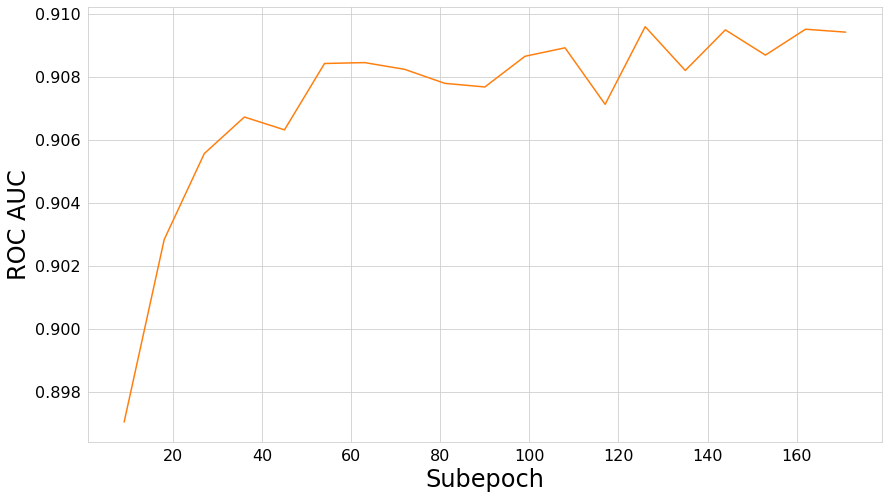

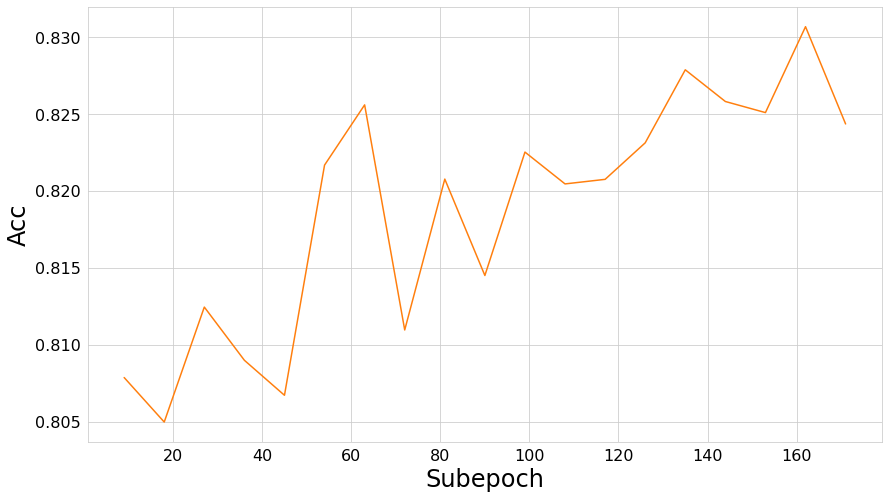

Mean loss = 2.8480570108513348e-05±0.0
Mean ROC AUC = 0.9095825405454381±0.0
Mean Acc = 0.823145201270627±0.0
______________________________________



In [35]:
from lumin.nn.training.train import train_models

results, histories, cycle_losses = train_models(train_fy,  # Training data
                                                n_models=1,  # Number of models to train
                                                model_builder=model_builder,  # How to build models, losses, and optimisers
                                                bs=bs,  # Batch size
                                                n_epochs=30,  # Maximum number of epochs to train
                                                patience=5,  # If not None, stop training if validation loss doesn't improve after set number of epochs (automatic save best)
                                                metric_partials=metric_partials)  # Pass our evaluation metrics

In [36]:
from lumin.nn.models.model import Model

model = Model.from_save('train_weights/model_id_0/train_0.h5', model_builder)

In [37]:
#Prediction and evaluation
val_fy = FoldYielder(PATH/'val.hdf5'); val_fy

FoldYielder with 10 folds, containing ['inputs', 'targets']

In [38]:
model.predict(val_fy)
val_fy

FoldYielder with 10 folds, containing ['inputs', 'pred', 'targets']

In [39]:
#Evaluation
val_df = val_fy.get_df(); val_df.head()

6513 datapoints loaded


,gen_target,pred
0,0,0.816448
1,0,0.460731
2,1,0.973116
3,0,0.487156
4,0,0.663245


In [40]:
#We can load a Pandas DataFrame from the FoldYielder using:
val_df = val_fy.get_df(inc_inputs=True); val_df.head()

6513 datapoints loaded


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,gen_target,pred
0,0.690419,0.717358,0.744263,-0.146647,-0.212386,-0.032432,2.0,2.0,5.0,7.0,0.0,3.0,0.0,33.0,0,0.816448
1,0.617121,-0.756809,-0.414712,-0.146647,-0.212386,1.589837,3.0,3.0,2.0,13.0,3.0,3.0,0.0,33.0,0,0.460731
2,0.690419,0.014584,2.289564,-0.146647,4.610246,1.589837,2.0,1.0,5.0,7.0,0.0,3.0,0.0,33.0,1,0.973116
3,0.617121,-0.384737,1.516913,-0.146647,-0.212386,0.778702,2.0,11.0,0.0,7.0,3.0,3.0,1.0,33.0,0,0.487156
4,1.643301,-1.166141,-0.414712,-0.146647,-0.212386,-0.032432,3.0,3.0,5.0,10.0,0.0,3.0,0.0,33.0,0,0.663245


In [41]:
#Or if we want the unpreprocessed inputs:
val_fy.add_input_pipe_from_file(PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True, deprocess=True, nan_to_num=True); val_df.head()

6513 datapoints loaded


,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,gen_target,pred
0,48.0,265477.000000,12.0,-0.000058,-8.247994e-07,40.0,2.0,2.0,5.0,7.0,0.0,3.0,0.0,33.0,0,0.816448
1,47.0,109832.000000,9.0,-0.000058,-8.247994e-07,60.0,3.0,3.0,2.0,13.0,3.0,3.0,0.0,33.0,0,0.460731
2,48.0,191277.000000,16.0,-0.000058,1.902000e+03,60.0,2.0,1.0,5.0,7.0,0.0,3.0,0.0,33.0,1,0.973116
3,47.0,149116.000000,14.0,-0.000058,-8.247994e-07,50.0,2.0,11.0,0.0,7.0,3.0,3.0,1.0,33.0,0,0.487156
4,61.0,66614.007812,9.0,-0.000058,-8.247994e-07,40.0,3.0,3.0,5.0,10.0,0.0,3.0,0.0,33.0,0,0.663245


In [47]:
#Evaluate the model using the accuracy of its predictions
from sklearn.metrics import accuracy_score

accuracy = round(accuracy_score(y_true=val_df.gen_target, y_pred=val_df.pred.round()),2)*100
accuracy

81.0

In [48]:
accuracy_score(y_true=val_fy.get_column('targets'), y_pred=val_fy.get_column('pred').round())

0.8139106402579457

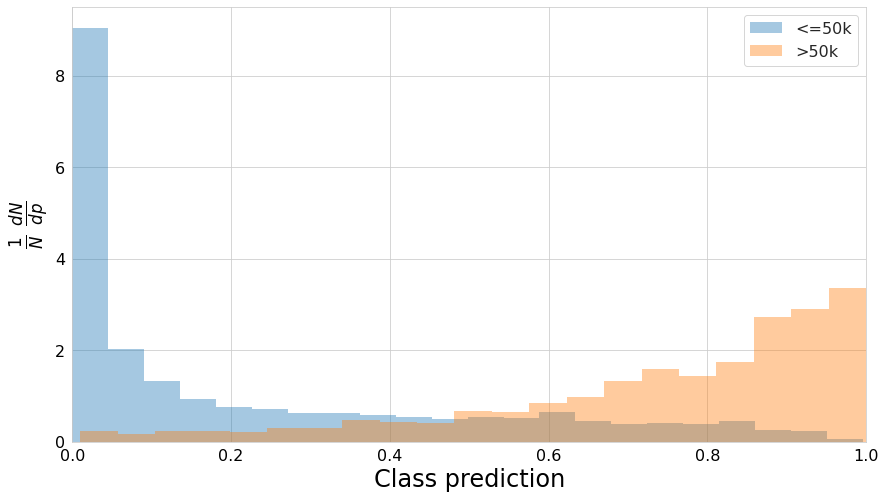

In [49]:
#We can also plot out the distribution of predictions by class
from lumin.plotting.results import plot_binary_class_pred
from lumin.plotting.plot_settings import PlotSettings

plot_binary_class_pred(val_df, settings=PlotSettings(targ2class={0:'<=50k', 1:'>50k'}))

Interpretation
We can see exactly how important each input feature is to our model by computing the permutation importance for each feature. An explanation of PI may be found here Beware Default Random Forest Importances. PI is a measure of how much the model degrades when the information carried by a feature is destroyed. A greater degradation implies that the model relies more on the feature.

PI in LUMIN can be computed by a single function, and if we pass it the training data as a FoldYielder it will compute the average importance over the folds.

Top ten most important features:
          Feature  Importance  Uncertainty
0    CapitalGain    0.891979     0.194720
1  MaritalStatus    0.613533     0.048240
2            Age    0.257544     0.028308
3   EducationNum    0.205761     0.023189
4   HoursPerWeek    0.101273     0.015381
5     Occupation    0.094771     0.016749
6   Relationship    0.031700     0.004910
7    CapitalLoss    0.023257     0.005809
8         Gender    0.021398     0.006380
9      WorkClass    0.015266     0.006300


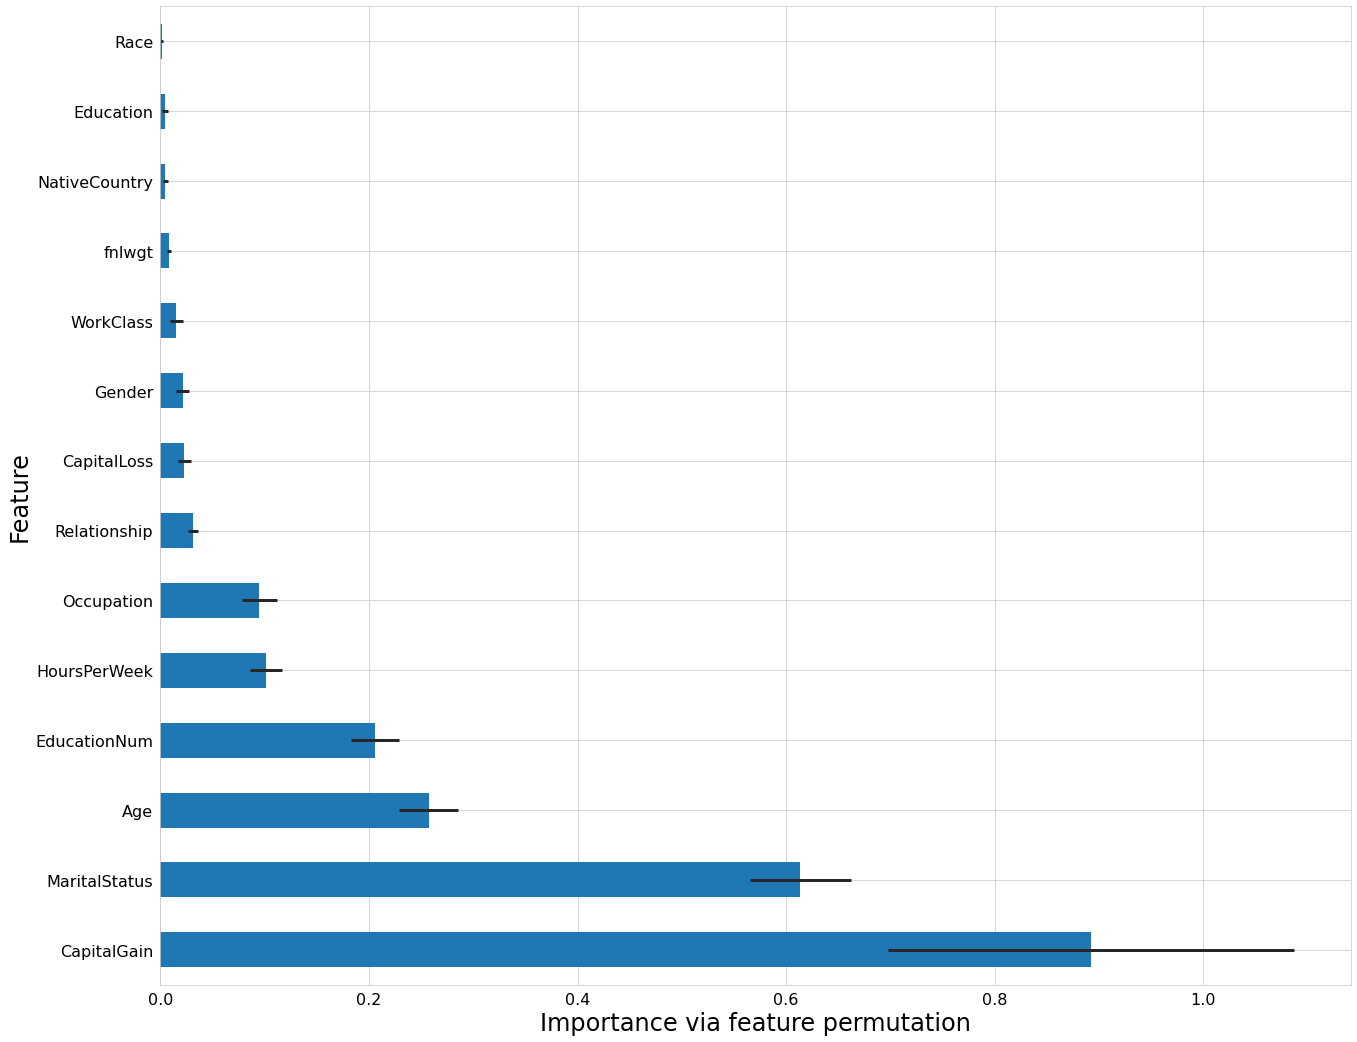

In [50]:
fi = model.get_feat_importance(train_fy)

From this we can see that the model heavily relies on CapitalGain, but also uses a range of other features to support its decisions.